In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.display import Image

In [32]:
# Reading data
data = pd.read_csv('macro.csv')
data

,Date,GDP,PCEC,GDP_Implicit_Price_Deflator_inflation,CPI_less_food_and_energy,total_CPI,Investments,Inventories,Wilshire_5000_Full_Cap_Price_Index
0,1947-01-01,243.164,156.161,NaN,NaN,NaN,35.854,92.806,NaN
1,1947-04-01,245.968,160.031,5.8,NaN,NaN,34.505,93.945,NaN
2,1947-07-01,249.585,163.543,6.9,NaN,NaN,34.911,99.300,NaN
3,1947-10-01,259.745,167.672,10.2,NaN,NaN,43.250,106.731,NaN
4,1948-01-01,265.742,170.372,3.2,NaN,NaN,47.202,103.061,NaN
...,...,...,...,...,...,...,...,...,...
297,2021-04-01,23046.934,15813.545,6.4,2.504185,0.339103,3943.400,3176.816,43813.322344
298,2021-07-01,23550.420,16147.297,6.2,2.442802,0.287313,4109.122,3239.884,45986.152188
299,2021-10-01,24349.121,16517.976,6.8,3.238340,0.388553,4499.171,3394.375,47478.708594
300,2022-01-01,24740.480,16874.769,8.4,4.277553,0.532822,4671.027,3611.694,45005.218065


In [33]:
# Choose data as in the article
data_to_filter = data[['Date', 'GDP', 'PCEC', 'CPI_less_food_and_energy']].rename(columns = {'PCEC': 'Consumption', 'CPI_less_food_and_energy' : 'CPI'}).copy()
data_to_filter = data_to_filter[(data_to_filter["Date"] >= "1970-01-01") & (data_to_filter["Date"] <= "1999-01-01")].set_index('Date')
data_to_filter

,GDP,Consumption,CPI
Date,,,
1970-01-01,1051.200,631.685,6.916757
1970-04-01,1067.375,641.570,7.010863
1970-07-01,1086.059,653.482,7.107600
1970-10-01,1088.608,660.161,7.284990
1971-01-01,1135.156,679.186,6.312204
...,...,...,...
1998-01-01,8866.480,5721.342,2.690487
1998-04-01,8969.699,5832.566,2.627481
1998-07-01,9121.097,5926.846,2.620165


In [34]:
# Создаем функцию вывода корреляций и стандартного отклонения для каждого столбца
def cross_cor(df, HP_par : int, BXKG_par : list, show_tests : bool):
    df = df.copy().to_frame()
    name = df.columns[0]
    df = np.log(df)

    # Hodrick-Prescott filtering
    df[f'{name}_HP Filter'] = sm.tsa.filters.hpfilter(df, lamb=HP_par)[0]

    # Baxter and King filtering
    for par in BXKG_par:
        df[f'{name}_BXKG {par}'] = sm.tsa.filters.bkfilter(df[name], par[0], par[1], par[2])

    df.drop(columns=[name], inplace=True)

    # Stationarity analysis with Dickey-fuller test
    # Bool 'show_tests' presents Dickey-fuller information
    if show_tests:
        for col in df.columns:
            test = sm.tsa.adfuller(df[col].dropna())
            print(f'Dickey-Fuller test for {col}')
            if test[1] <= 0.05:
                print(f'Series "{col}" is stationary at the significance level 5%\n')
            else:
                print(f'Series "{col}" is not stationary at the significance level 5%\n')

            print('stat adf = %.3f'%test[0])
            print('p_value = %.3f'%test[1])
            # print('1%%:\t %.3f'%test[4]['1%'])
            print('5%%:\t %.3f'%test[4]['5%'])
            # print('10%%: %.3f'%test[4]['10%'])
            print('__________________________________________\n')

    # Standard deviation calculating
    df_std = df.std().to_frame(name='St. Deviation').round(3)

    # Correlation calculating
    df_corr = df.corr().round(3)

    # Merging calculations
    df_out = df_std.merge(df_corr, left_index=True, right_index=True)
    return df_out

cols = ['GDP', 'Consumption', 'CPI']
for col in cols:
    print(cross_cor(data_to_filter[col], 1600, [(6, 40, 12), (6, 40, 8), (6, 32, 8)], False))

                      St. Deviation  GDP_HP Filter  GDP_BXKG (6, 40, 12)  \
GDP_HP Filter                 0.012          1.000                 0.923   
GDP_BXKG (6, 40, 12)          0.013          0.923                 1.000   
GDP_BXKG (6, 40, 8)           0.011          0.908                 0.935   
GDP_BXKG (6, 32, 8)           0.010          0.903                 0.928   

                      GDP_BXKG (6, 40, 8)  GDP_BXKG (6, 32, 8)  
GDP_HP Filter                       0.908                0.903  
GDP_BXKG (6, 40, 12)                0.935                0.928  
GDP_BXKG (6, 40, 8)                 1.000                1.000  
GDP_BXKG (6, 32, 8)                 1.000                1.000  
                              St. Deviation  Consumption_HP Filter  \
Consumption_HP Filter                 0.008                  1.000   
Consumption_BXKG (6, 40, 12)          0.008                  0.860   
Consumption_BXKG (6, 40, 8)           0.006                  0.883   
Consumption_BX

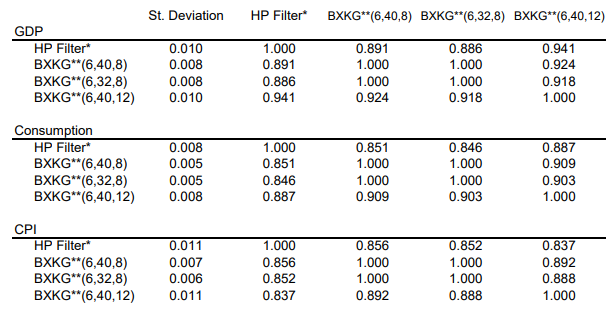

In [35]:
# Comparing to the article
Image('Article.png')